In [1]:
import pickle
import torch
import copy
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision

from train import train
from model import AutoEncoder

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

f = open("all_jets_train_4D_100_percent.pkl", 'rb')
data = pickle.load(f).to_numpy()
data_tensor = torch.tensor(data, dtype=torch.float).to(device)

In [44]:
data

array([[ 3.83183936e+03,  2.20006094e+04,  1.56701827e+00,
         1.14292371e+00],
       [ 4.58241748e+03,  2.16482109e+04, -2.68055797e+00,
         2.13654295e-01],
       [ 1.67477656e+04,  1.69514281e+05, -1.94823873e+00,
         1.16329563e+00],
       ...,
       [ 5.57433252e+03,  2.41444902e+04,  1.22654164e+00,
         1.52209246e+00],
       [ 4.34143066e+03,  2.34369629e+04, -2.39788198e+00,
         1.15190649e+00],
       [ 5.15032275e+03,  2.37615605e+04,  3.02371287e+00,
        -1.30649364e+00]])

Now we are forming pytorch dataset splitting a validation set from it for the early stop.

In [53]:
data_len = data_tensor.shape[0]
val_size = data_len//5

dataset = torch.utils.data.TensorDataset(data_tensor)

#train_set, val_set = torch.utils.data.random_split(dataset, [data_len - val_size, val_size])

batch = 10000

data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch)

model = AutoEncoder().to(device)

For the training we will use the Adam optimizer and the patience training model. If the performance of the model on the validation set is not improving after a number of epochs, we're halting the training.

As a loss we are using RMSE loss for ease of interpretability.


In [2]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = torch.nn.MSELoss()


In [56]:
train_losses , val_losses = train(model, data_loader, loss_func, batch, data_len - val_size, 1000,100)

    

Epoch: 0/1000, current validation loss: 3756046.5
Epoch: 1/1000, current validation loss: 3144059.0833333335
Epoch: 2/1000, current validation loss: 2849282.4166666665
Epoch: 3/1000, current validation loss: 2391276.4166666665
Epoch: 4/1000, current validation loss: 1946201.3333333333
Epoch: 5/1000, current validation loss: 1470466.4166666667
Epoch: 6/1000, current validation loss: 1006522.1041666666
Epoch: 7/1000, current validation loss: 490237.09375
Epoch: 8/1000, current validation loss: 191830.39583333334
Epoch: 9/1000, current validation loss: 43336.299479166664
Epoch: 10/1000, current validation loss: 9444.953776041666
Epoch: 11/1000, current validation loss: 12994.054361979166
Epoch: 12/1000, current validation loss: 10074.636067708334
Epoch: 13/1000, current validation loss: 6033.310872395833
Epoch: 14/1000, current validation loss: 4621.591634114583
Epoch: 15/1000, current validation loss: 3901.6549479166665
Epoch: 16/1000, current validation loss: 3043.353759765625
Epoch: 17

Epoch: 138/1000, current validation loss: 2399.246826171875
Epoch: 139/1000, current validation loss: 1700.6398111979167
Epoch: 140/1000, current validation loss: 975.3603922526041
Epoch: 141/1000, current validation loss: 567.5058186848959
Epoch: 142/1000, current validation loss: 229.78569539388022
Epoch: 143/1000, current validation loss: 59.43335469563802
Epoch: 144/1000, current validation loss: 230.26021830240884
Epoch: 145/1000, current validation loss: 5052.344075520833
Epoch: 146/1000, current validation loss: 69186.96354166667
Epoch: 147/1000, current validation loss: 21361.627604166668
Epoch: 148/1000, current validation loss: 7522.503092447917
Epoch: 149/1000, current validation loss: 2060.0096028645835
Epoch: 150/1000, current validation loss: 649.0547485351562
Epoch: 151/1000, current validation loss: 295.91980997721356
Epoch: 152/1000, current validation loss: 115.64929453531902
Epoch: 153/1000, current validation loss: 70.3722635904948
Epoch: 154/1000, current validatio

Epoch: 274/1000, current validation loss: 8997.387369791666
Epoch: 275/1000, current validation loss: 42806.303385416664
Epoch: 276/1000, current validation loss: 7568.895345052083
Epoch: 277/1000, current validation loss: 2290.64990234375
Epoch: 278/1000, current validation loss: 1208.762451171875
Epoch: 279/1000, current validation loss: 955.1843058268229
Epoch: 280/1000, current validation loss: 746.7619832356771
Epoch: 281/1000, current validation loss: 404.57372029622394
Epoch: 282/1000, current validation loss: 102.28064473470052
Epoch: 283/1000, current validation loss: 20.46384874979655
Epoch: 284/1000, current validation loss: 232.7121785481771
Epoch: 285/1000, current validation loss: 394.26526896158856
Epoch: 286/1000, current validation loss: 87.58202616373698
Epoch: 287/1000, current validation loss: 121.8152567545573
Epoch: 288/1000, current validation loss: 1539.9141438802083
Epoch: 289/1000, current validation loss: 48160.915364583336
Epoch: 290/1000, current validation

In [57]:
model.load_state_dict(best_state)
torch.save(model, "model.pt")

In [58]:
print("Best loss on the validation set:  " + str(float(best_loss)))


Best loss on the validation set:  9.353011767069498


### Evaluation
On the plots below you can see the validation and training losses across time (they are nearly identical) in linear and log scale. You can see the gradual decline (better seen on the log scale) with a significant amount of noise spikes, typical for Adam.

Text(0.5, 0, 'Epoch')

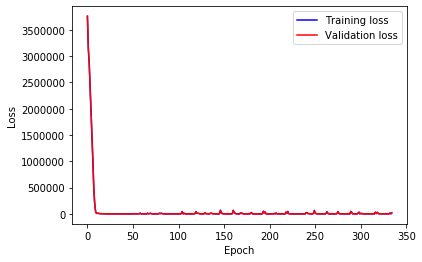

In [59]:
plt.plot(range(len(train_losses)), train_losses, 'b-', range(len(val_losses)), val_losses, 'r')
plt.legend(["Training loss","Validation loss"])
plt.ylabel('Loss')
plt.xlabel('Epoch')


Text(0.5, 0, 'Epoch')

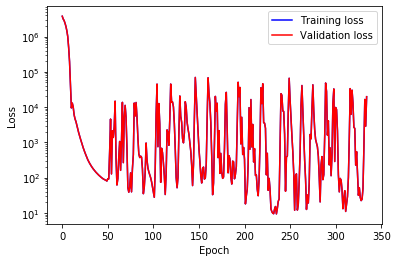

In [60]:
plt.plot(range(len(train_losses)), train_losses, 'b-', range(len(val_losses)), val_losses, 'r')
plt.yscale('log')
plt.legend(["Training loss","Validation loss"])         

plt.ylabel('Loss')
plt.xlabel('Epoch')


For the testing we will find the average loss and the scaled difference between original values and recreated ones.

In [61]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

f = open("all_jets_test_4D_100_percent.pkl", 'rb')
data = pickle.load(f).to_numpy()
data_tensor = torch.tensor(data, dtype=torch.float).to(device)

data_len = data_tensor.shape[0]

dataset = torch.utils.data.TensorDataset(data_tensor)

batch = 10000

data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch)


In [62]:
model.eval()


optimizer.zero_grad()
pred = model(data_tensor)
loss = loss_func(pred, data_tensor)
   
print("Test loss: " + str(float(loss)))

Test loss: 9.467355728149414


In [91]:
pT_diff =  data_tensor[:,0] - pred[:,0] / data_tensor[:,0]
eta_diff =  data_tensor[:,1] - pred[:,1] / data_tensor[:,1]
phi_diff =  data_tensor[:,2] - pred[:,2] / data_tensor[:,2]
E_diff = data_tensor[:,3] - pred[:,3] / data_tensor[:,3]

Text(0.5, 0, 'Sample')

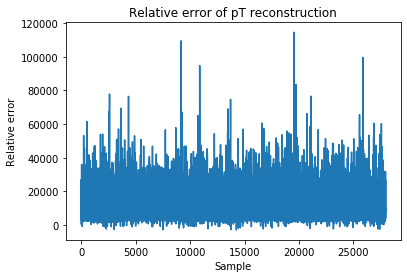

In [94]:
plt.plot(pT_diff.detach().cpu())
plt.title("Relative error of pT reconstruction")
plt.ylabel('Relative error')
plt.xlabel('Sample')


Text(0.5, 0, 'Sample')

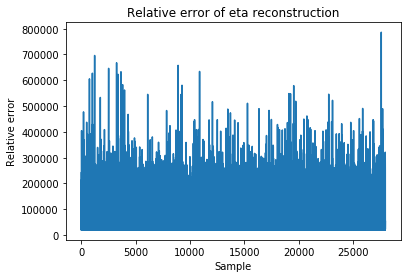

In [95]:
plt.plot(eta_diff.detach().cpu())
plt.title("Relative error of eta reconstruction")
plt.ylabel('Relative error')
plt.xlabel('Sample')

Text(0.5, 0, 'Sample')

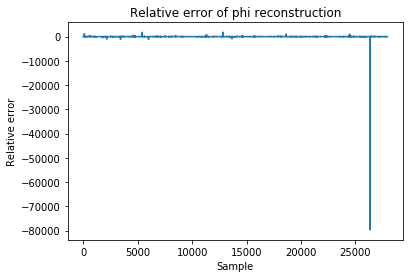

In [96]:
plt.plot(phi_diff.detach().cpu())
plt.title("Relative error of phi reconstruction")
plt.ylabel('Relative error')
plt.xlabel('Sample')

Text(0.5, 0, 'Sample')

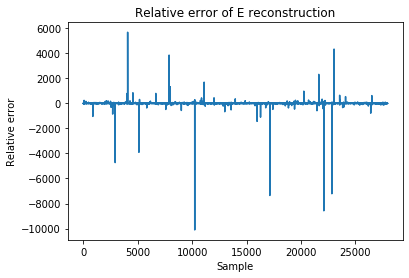

In [97]:
plt.plot(E_diff.detach().cpu())
plt.title("Relative error of E reconstruction")
plt.ylabel('Relative error')
plt.xlabel('Sample')

As we can see, the autoencoder is extremely good at reconstructing E and phi, but superficially seem terrible on reconstructing Eta and Pt. But we can check it by looking at the absolute error instead of the relative error.

In [112]:
pT_diff =  data_tensor[:,0] - pred[:,0] 
eta_diff =  data_tensor[:,1] - pred[:,1] 
phi_diff =  data_tensor[:,2] - pred[:,2]
E_diff = data_tensor[:,3] - pred[:,3] 

Text(0.5, 0, 'Sample')

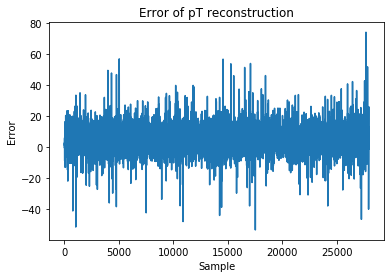

In [117]:
plt.plot(pT_diff.detach().cpu())
plt.title("Error of pT reconstruction")
plt.ylabel('Error')
plt.xlabel('Sample')


Text(0.5, 0, 'Sample')

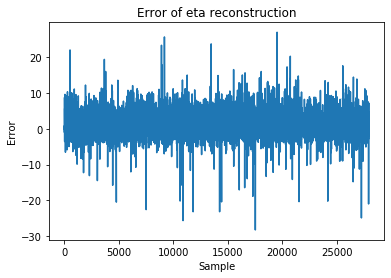

In [118]:
plt.plot(eta_diff.detach().cpu())
plt.title("Error of eta reconstruction")
plt.ylabel('Error')
plt.xlabel('Sample')

Text(0.5, 0, 'Sample')

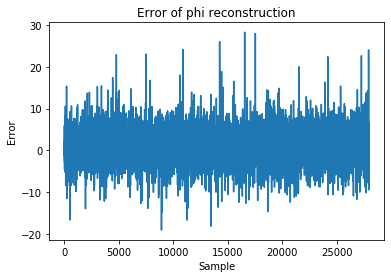

In [119]:
plt.plot(phi_diff.detach().cpu())
plt.title("Error of phi reconstruction")
plt.ylabel('Error')
plt.xlabel('Sample')

Text(0.5, 0, 'Sample')

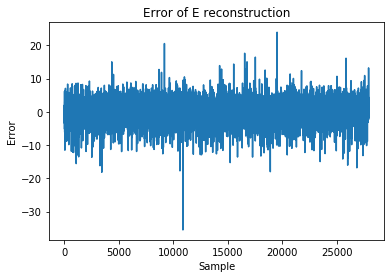

In [120]:
plt.plot(E_diff.detach().cpu())
plt.title("Error of E reconstruction")
plt.ylabel('Error')
plt.xlabel('Sample')

As we can see, the absolute errors of reconstructions correspond to our loss and are virtually identical. From this we may make a conclusion, that the autoencoder does not prioritize input channels and the relative difference is so high for the pT and Eta since their values are extremely small on average, while values of phi and E are large, resulting in similar errors, but different relative errors. We can try to alleviate it using the scaling loss function, or by scaling and normalizing the input. 

### Assuming, we are normalizing the input:

In [23]:
def normalize(data):
    std = np.std(data, axis = 0)
    mean = np.mean(data,axis = 0)

    return (data - mean) / std, mean, std




In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

f = open("all_jets_train_4D_100_percent.pkl", 'rb')
data, mean, std = normalize(pickle.load(f).to_numpy())



In [5]:
data_tensor = torch.tensor(data, dtype=torch.float).to(device)


In [6]:
data_len = data_tensor.shape[0]
val_size = data_len//5

dataset = torch.utils.data.TensorDataset(data_tensor)

batch = 10000

data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch)

model = AutoEncoder().to(device)

In [7]:
train_losses , val_losses, best_state = train(model, data_loader, loss_func, batch, data_len - val_size, 400, 100)


Epoch: 0/400, current validation loss: 0.8199934164683024
Epoch: 1/400, current validation loss: 0.47442805767059326
Epoch: 2/400, current validation loss: 0.23196897407372793
Epoch: 3/400, current validation loss: 0.07036059349775314
Epoch: 4/400, current validation loss: 0.06441673015554746
Epoch: 5/400, current validation loss: 0.03976387530565262
Epoch: 6/400, current validation loss: 0.03856626649697622
Epoch: 7/400, current validation loss: 0.034632102896769844
Epoch: 8/400, current validation loss: 0.03333854551116625
Epoch: 9/400, current validation loss: 0.032050819446643196
Epoch: 10/400, current validation loss: 0.03143616206943989
Epoch: 11/400, current validation loss: 0.03086291439831257
Epoch: 12/400, current validation loss: 0.030427617331345875
Epoch: 13/400, current validation loss: 0.030091943219304085
Epoch: 14/400, current validation loss: 0.029809572423497837
Epoch: 15/400, current validation loss: 0.02955512764553229
Epoch: 16/400, current validation loss: 0.0293

Epoch: 135/400, current validation loss: 0.017719474310676258
Epoch: 136/400, current validation loss: 0.01767391338944435
Epoch: 137/400, current validation loss: 0.01763017848134041
Epoch: 138/400, current validation loss: 0.017585905268788338
Epoch: 139/400, current validation loss: 0.017544268320004146
Epoch: 140/400, current validation loss: 0.01750278224547704
Epoch: 141/400, current validation loss: 0.01746206544339657
Epoch: 142/400, current validation loss: 0.017421616862217586
Epoch: 143/400, current validation loss: 0.017382080977161724
Epoch: 144/400, current validation loss: 0.017343552162249882
Epoch: 145/400, current validation loss: 0.01730542692045371
Epoch: 146/400, current validation loss: 0.017267501602570217
Epoch: 147/400, current validation loss: 0.017230452348788578
Epoch: 148/400, current validation loss: 0.01719408979018529
Epoch: 149/400, current validation loss: 0.017155538002649944
Epoch: 150/400, current validation loss: 0.017119893804192543
Epoch: 151/400

Epoch: 268/400, current validation loss: 0.014198876606921354
Epoch: 269/400, current validation loss: 0.014164235442876816
Epoch: 270/400, current validation loss: 0.014123104512691498
Epoch: 271/400, current validation loss: 0.014093769093354544
Epoch: 272/400, current validation loss: 0.014087416852513948
Epoch: 273/400, current validation loss: 0.014083286747336388
Epoch: 274/400, current validation loss: 0.014071921507517496
Epoch: 275/400, current validation loss: 0.0140547143916289
Epoch: 276/400, current validation loss: 0.014043611163894335
Epoch: 277/400, current validation loss: 0.014013609228034815
Epoch: 278/400, current validation loss: 0.013985825392107168
Epoch: 279/400, current validation loss: 0.013957471586763859
Epoch: 280/400, current validation loss: 0.0139428765202562
Epoch: 281/400, current validation loss: 0.013931521524985632
Epoch: 282/400, current validation loss: 0.013919376768171787
Epoch: 283/400, current validation loss: 0.013908430313070616
Epoch: 284/4

In [9]:
model.load_state_dict(best_state)
torch.save(model, "normalized_model.pt")

### Evaluation of normalization

As we can see, validation losses decrease significantly more stably and rapidly:



Text(0.5, 0, 'Epoch')

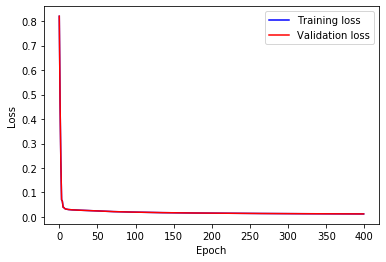

In [10]:
plt.plot(range(len(train_losses)), train_losses, 'b-', range(len(val_losses)), val_losses, 'r')
plt.legend(["Training loss","Validation loss"])
plt.ylabel('Loss')
plt.xlabel('Epoch')


Text(0.5, 0, 'Epoch')

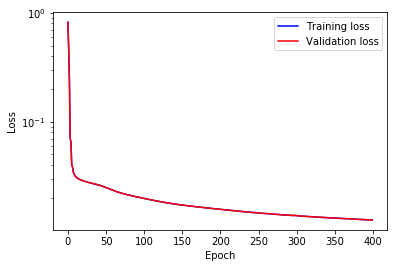

In [11]:
plt.plot(range(len(train_losses)), train_losses, 'b-', range(len(val_losses)), val_losses, 'r')
plt.yscale('log')
plt.legend(["Training loss","Validation loss"])         

plt.ylabel('Loss')
plt.xlabel('Epoch')


We will use the same mean and std of the training dataset to normalize our test dataset, since they are parameters, that would have been learned if we desired to use our autoencoder fo compression

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

f = open("all_jets_test_4D_100_percent.pkl", 'rb')

data = pickle.load(f).to_numpy()


data_tensor = torch.tensor(normalize(data)[0], dtype=torch.float).to(device)

data_len = data_tensor.shape[0]

dataset = torch.utils.data.TensorDataset(data_tensor)

batch = 10000

data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch)


In [29]:
model.eval()

pred = model(data_tensor)
loss = loss_func(pred, data_tensor)
   
print("Test loss: " + str(float(loss)))

Test loss: 0.012265239842236042


In [30]:
pT_diff =  data_tensor[:,0] - pred[:,0] / data_tensor[:,0]
eta_diff =  data_tensor[:,1] - pred[:,1] / data_tensor[:,1]
phi_diff =  data_tensor[:,2] - pred[:,2] / data_tensor[:,2]
E_diff = data_tensor[:,3] - pred[:,3] / data_tensor[:,3]

Text(0.5, 0, 'Sample')

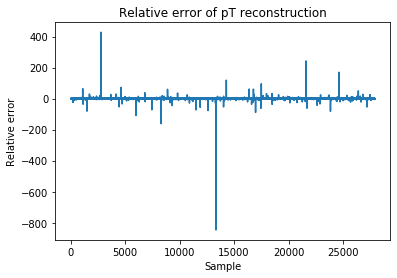

In [31]:
plt.plot(pT_diff.detach().cpu())
plt.title("Relative error of pT reconstruction")
plt.ylabel('Relative error')
plt.xlabel('Sample')


Text(0.5, 0, 'Sample')

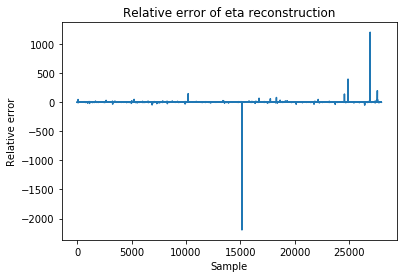

In [32]:
plt.plot(eta_diff.detach().cpu())
plt.title("Relative error of eta reconstruction")
plt.ylabel('Relative error')
plt.xlabel('Sample')

Text(0.5, 0, 'Sample')

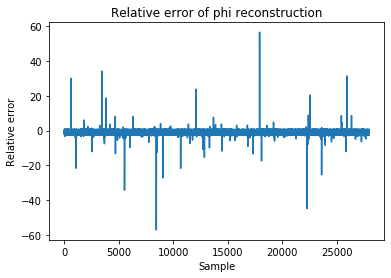

In [33]:
plt.plot(phi_diff.detach().cpu())
plt.title("Relative error of phi reconstruction")
plt.ylabel('Relative error')
plt.xlabel('Sample')

Text(0.5, 0, 'Sample')

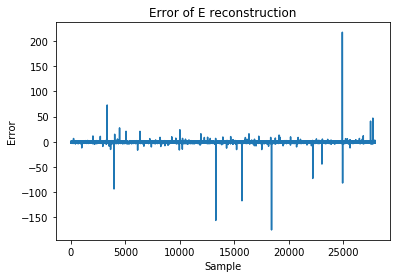

In [34]:
plt.plot(E_diff.detach().cpu())
plt.title("Error of E reconstruction")
plt.ylabel('Error')
plt.xlabel('Sample')

In [35]:
pT_diff =  data_tensor[:,0] - pred[:,0] 
eta_diff =  data_tensor[:,1] - pred[:,1] 
phi_diff =  data_tensor[:,2] - pred[:,2]
E_diff = data_tensor[:,3] - pred[:,3] 

As we can see, the errors after the normalization are virtually non-existent.